In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt

[[5.63436458]]
[[5.63436458]] [6.16407513]


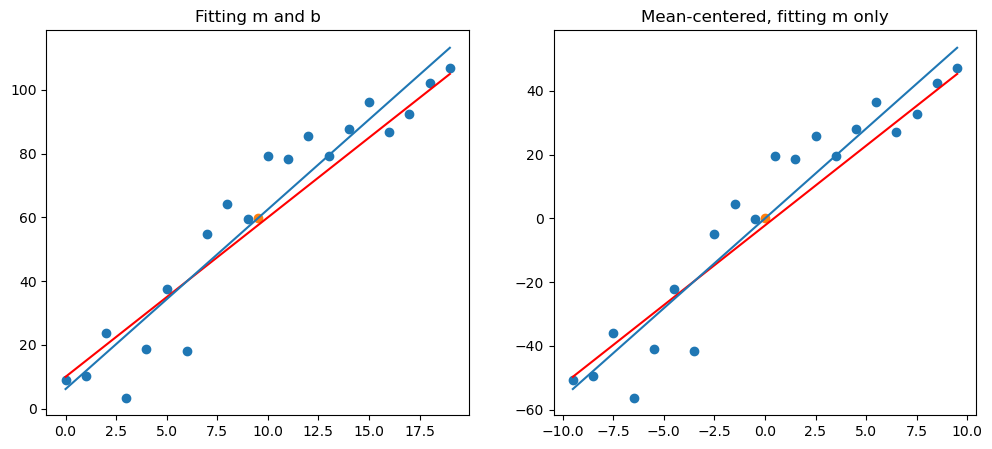

In [2]:
a_actual = 5
b_actual = 10
sigma = 10
npts = 20

rands = np.random.normal(loc=0.0, scale=sigma, size=(npts,))
inds = np.arange(npts, dtype=np.float64)
data = a_actual*inds + b_actual + rands
xhat = np.mean(inds)
yhat = np.mean(data)

model = LinearRegression().fit((inds-xhat)[:,None], (data-yhat)[:,None])
print(model.coef_)

plt.subplots(1, 2, figsize=(12,5))
plt.subplot(122)
plt.title('Mean-centered, fitting m only')
plt.scatter(inds-xhat, data-yhat)
plt.scatter([0],[0])
plt.plot(inds-xhat, a_actual*inds + b_actual - yhat, 'r')
plt.plot(inds-xhat, model.coef_[0,0]*(inds-xhat))

plt.subplot(121)
plt.title('Fitting m and b')
plt.scatter(inds, data)
# print(np.vstack([np.ones_like(inds), inds]).T)
model2 = LinearRegression(fit_intercept=True).fit(
    X=inds[:,None],
    y=data[:,None]
)
print(model2.coef_, model2.intercept_)
plt.plot(inds, a_actual*inds + b_actual, 'r')
plt.plot(inds, model2.coef_[0,0]*inds + model2.intercept_[0])
plt.scatter([xhat],[yhat])


(array([0.00280852, 0.00936173, 0.0238724 , 0.03557456, 0.04914906,
        0.05242566, 0.03510647, 0.01919154, 0.00421278, 0.00234043]),
 array([154.00105429, 158.27377098, 162.54648767, 166.81920436,
        171.09192105, 175.36463773, 179.63735442, 183.91007111,
        188.1827878 , 192.45550449, 196.72822117]),
 <BarContainer object of 10 artists>)

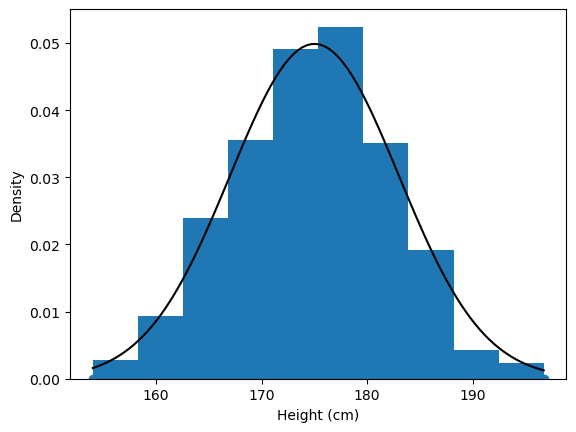

In [47]:
height_u = 175
height_s = 8
nsamples = 500

heights = np.random.normal(loc=height_u, scale=height_s, size=(nsamples,))
plt.scatter(heights, np.zeros_like(heights))
xs = np.linspace(np.min(heights), np.max(heights), 100)
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.plot(xs, stats.norm.pdf(xs, loc=height_u, scale=height_s), 'k')
plt.hist(heights, density=True, bins=10)

In [4]:
import altair as alt
import pandas as pd

m_slider = alt.binding_range(min=0, max=15, name="Slope (m): ")
m_var = alt.param(bind=m_slider, value=1, name='m')
b_slider = alt.binding_range(min=int(min(data)), max=int(max(data))+1, name="Intercept : ")
b_var = alt.param(bind=b_slider, value=0, name='b')

line_df = pd.DataFrame({'x':inds,'y':data})

base = alt.Chart(line_df).mark_point().encode(
    x=alt.X('x:Q', title='Time'),
    y=alt.Y('y:Q', title="Value")
)
slope_intercept = alt.Chart().mark_rule().transform_calculate(
    y='b',
    y2='20*m+b'
).encode(
    x=alt.datum(0),
    x2=alt.datum(max(inds)),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[0, 120])),
    y2='y2:Q'
).add_params(
    m_var,
    b_var
)
base + slope_intercept

alt.LayerChart(...)

In [143]:
u_slider = alt.binding_range(min=150, max=200, name="Mean (𝜇): ")
u_var = alt.param(bind=u_slider, value=165, name='u')
s_slider = alt.binding_range(min=1, max=30, name='Standard deviation (𝜎): ')
s_var = alt.param(bind=s_slider, value=3, name='s')

x_pts = np.linspace(min(heights), max(heights), 300)
height_df = pd.DataFrame({'h':heights})
norm_df = pd.DataFrame({'x':x_pts})

hist = alt.Chart(height_df).mark_bar().encode(
    alt.X('h:Q', title="Height (cm)").bin(step=1),
    y=alt.Y('sum(pct):Q', title="Density")
).transform_joinaggregate(
    total='count(*)'
).transform_calculate(
    pct='1 / datum.total'
)
gaussian = alt.Chart(norm_df).mark_line().transform_calculate(
    eps='exp(-pow((datum.x - u)/s,2)) * 1/(sqrt(2*PI)*s)',
).encode(
    x=alt.X('x:Q'),
    y=alt.Y('eps:Q'),
    color=alt.value('red')
).add_params(
    u_var,
    s_var
)
log_likelihood = alt.Chart(height_df).transform_calculate(
    ll='-pow((datum.h - u)/s,2) - 0.5*log(2*PI) - log(s)'
).transform_aggregate(
    tll='sum(ll)'
).transform_calculate(
    lk=alt.datum.tll/alt.expr.log(10),
    lk_base=alt.expr.ceil(alt.datum.lk),
    lk_exp=alt.expr.pow(10,-(alt.datum.lk-alt.datum.lk_base)),
    lk_exp_rounded=alt.expr.round(alt.datum.lk_exp*100)/100,
    text="Data likelihood: " + alt.datum.lk_exp_rounded + "E" + alt.datum.lk_base
).mark_text().encode(
    y=alt.value(0),
    text='text:N'
).add_params(
    u_var,
    s_var
)

hist + gaussian + log_likelihood

alt.LayerChart(...)